In [3]:
!pip install --upgrade pip
!pip install --upgrade scipy tensorflow tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5a/f2/5c2f878c62c8b79c629b11b33516bb55054d7677eba6f56f3a20296b56bd/tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 38.7 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for keras<2.14,>=2.13.1 from https://files.pythonhosted.org/packages/2e/f3/19da7511b45e80216cbbd9467137b2d28919c58ba1ccb971435cb631e470/keras-2.13.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.8 MB/s eta 0:00:00:00:0100:01
  Obtaining dependency information for tensorflow-estimator<2.14,>=2.13.0 from https://files.pythonhosted.org/packages/72/5c/c3182

In [4]:
# Import necessary libraries and modules

import tensorflow as tf
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns 
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm

In [5]:
# List the contents of the directory
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [11]:
# Set the paths for the dataset and files
path = "../input/planets-dataset/planet/planet/"
train_img_path = os.path.join(path, "train-jpg") #training images
test_img_path = os.path.join(path, "test-jpg") #test images
train_class_path = os.path.join(path, "train_classes.csv")
sample_submission_path = os.path.join(path, "sample_submission.csv")

In [13]:
# Read the training classes and sample submission files
train_classes = pd.read_csv(train_class_path)
sample_sub = pd.read_csv(sample_submission_path)


In [15]:
# Print the shape of the training classes and sample submission DataFrame
print(train_classes.shape)
print(sample_sub.shape)

(40479, 2)
(61191, 2)


In [16]:
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [17]:
# Extracting tags and printing the unique classes

from itertools import chain 
labels_list = list(chain.from_iterable([tags.split(" ")
for tags in train_classes['tags'].values]))

num_labels = len(labels_list)
unique_labels = set(labels_list)
num_unique = len(unique_labels)
print("There are {} labels in the training set".format(num_labels))
print("and {} unique labels".format(num_unique))    
print("which are {}".format(unique_labels)) 

There are 116278 labels in the training set
and 17 unique labels
which are {'agriculture', 'water', 'road', 'haze', 'bare_ground', 'habitation', 'cloudy', 'blow_down', 'artisinal_mine', 'cultivation', 'partly_cloudy', 'clear', 'slash_burn', 'selective_logging', 'conventional_mine', 'primary', 'blooming'}


In [18]:
# Initialization and Image Reading

# Initialize empty lists to store the training images and their labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_classes['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(train_classes.values, miniters=1000):
    # Read the image file
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    # Initialize an array of zeros for the targets
    targets = np.zeros(17)
    # Loop through the tags for the current image
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Append the resized image and its labels to the appropriate lists
    x_train.append(cv2.resize(img, (64, 64)))  # Resize the image to a specific size
    y_train.append(targets)

# Convert the lists to numpy arrays
x_train = np.array(x_train, np.float16) / 255 #normalize the pixel values
y_train = np.array(y_train, np.uint8)

100%|██████████| 40479/40479 [05:25<00:00, 124.19it/s]


In [19]:
#Converting the lists of images and labels to numpy arrays and normalizing the pixel values of the images. 
#y_train = np.array(y_train, np.uint8)
#x_train = np.array(x_train, np.float16)/ 255.

#Splitting the data into train and validation sets. 
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 20)

#Prints the shape of the training and validation data.
print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)
print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)

Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


In [22]:
def fbeta_score_K(y_true, y_pred):
    """
    Calculate the F-beta score using Keras backend operations.
    
    Parameters:
    - y_true: True labels or targets
    - y_pred: Predicted labels or targets
    
    Returns:
    - F-beta score
    """
    beta_squared = 4

    # Calculate true positives, false positives, and false negatives
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    # Calculate precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calculate the F-beta score
    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    
    return result


In [24]:
def my_model():
    """
    Create and return a customized convolutional neural network (CNN) model.
    
    Returns:
    - The created CNN model
    """
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64, 64, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model


In [25]:
# Create the model and display its summary
model = my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 64, 64, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        1

In [26]:
# Compile the model and set up early stopping callback
model.compile(loss='binary_crossentropy',
            optimizer = 'adam' ,
            metrics=[fbeta_score_K,'accuracy'])
callback = EarlyStopping(
                    monitor= 'val_loss', 
                    patience=2,
                    verbose=2,
                    baseline=None,
                    restore_best_weights =True)

In [27]:
# Data augmentation configuration

# Create an instance of ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
# Fit the data generator on the training data
data_gen.fit(x_train)

# Fit the data generator on the validation data
data_gen.fit(x_val)

In [28]:
# Calculate the number of steps per epoch for training and validation

train_steps = len(x_train)//64
val_steps = len(x_val)//64

In [29]:
# Model training
history = model.fit_generator(data_gen.flow(x_train,y_train,batch_size = 64),
                    steps_per_epoch = train_steps,
                    validation_data =data_gen.flow(x_val,y_val,batch_size = 64),
                    validation_steps = val_steps,
                    epochs=15,
                    callbacks=[callback])

/tmp/ipykernel_32/1356532934.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_gen.flow(x_train,y_train,batch_size = 64),


Epoch 1/15
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7cfd175d7e20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
505/505 [==============================] - ETA: 0s - loss: 0.2170 - fbeta_score_K: 0.6296 - accuracy: 0.0191WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7cfd168a6680> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7cfd168a6680>. Note that functions defined in certain environments, like the i

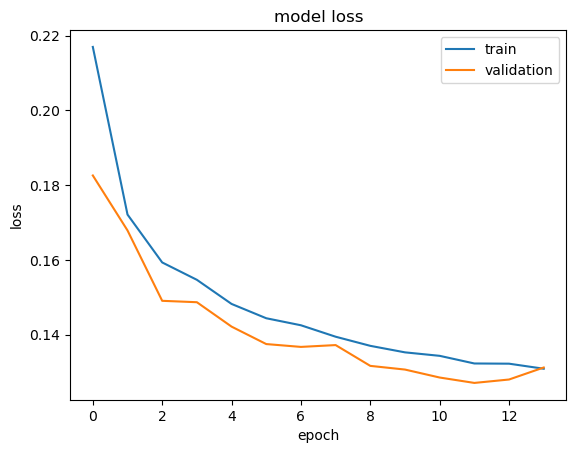

In [30]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper right')

# Showing the plot
plt.show()

In [31]:
# Evaluate the model's performance on the validation data
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100 - score * 100))

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7cfd0392a290>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
127/127 [==============================] - 28s 222ms/step
F beta score:  0.8926253527195737
Error: 10.74%


In [32]:
# The DataFrame 'sample_sub' now holds the data from the sample submission CSV file

# Create two separate DataFrames for the test and additional test files

# The first DataFrame will store the labels for the test-jpg files
test = sample_sub[0:40669]

# The second DataFrame will store the labels for the test-jpg-additional files
files = sample_sub[40669:]


In [33]:
# Initialize an empty list to store the images
test_img = []

# Loop through the test DataFrame to process the test-jpg files
for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Loop through the additional test files DataFrame to process the test-jpg-additional files
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Convert the list of images to a numpy array and normalize the pixel values
test_img = np.array(test_img, np.float16) / 255.0

# Calculate the number of steps for test data
test_steps = len(test_img) // 64


100%|██████████| 20522/20522 [02:17<00:00, 149.08it/s]


In [34]:
# Running the predictions

# Create an empty list to store the predicted labels
y_predictions = []

# Use the trained model to predict labels for the test images
predictions = model.predict(test_img, batch_size=64, verbose=2)

# Add the predicted labels to the y_predictions list
y_predictions.append(predictions)


957/957 - 222s - 222s/epoch - 232ms/step


In [35]:
# Forming the final submission

# Initialize an empty array to store the decoded labels
sub = np.array(y_predictions[0])

# Loop through the encoded labels
for i in range(1, len(y_predictions)):
    # Add the encoded label to the array
    sub += np.array(y_predictions[i])

# Convert the array to a DataFrame
sub = pd.DataFrame(sub, columns=label_map)


In [36]:
# Creating the submission file format

# Initialize an empty list to store the predictions
preds = []

# Loop through the sample submission DataFrame
for i in tqdm(range(sub.shape[0]), miniters=1000):
    # Get the i-th row of the DataFrame
    row = sub.loc[[i]]
    # Check which columns have values greater than 0.2 using a Boolean array
    filtered_row = row.apply(lambda x: x > 0.2, axis=1)
    # Transpose the DataFrame
    transposed_row = filtered_row.transpose()
    # Get the rows where the Boolean array is True
    selected_rows = transposed_row.loc[transposed_row[i] == True]
    # Join the index of the DataFrame (which contains the tags) into a single string
    tags_string = ' '.join(list(selected_rows.index))
    # Append the string of tags to the preds list
    preds.append(tags_string)

# Assign the preds list as the 'tags' column of the sample submission DataFrame
sample_sub['tags'] = preds

# Save the sample submission DataFrame to a CSV file named 'samp_submission.csv'
sample_sub.to_csv('samp_submission.csv', index=False)


100%|██████████| 61191/61191 [01:50<00:00, 551.59it/s]
